# Imports

In [1]:
from IPython.display import clear_output

!pip install pyprind

clear_output()

In [2]:
from google.colab.patches import cv2_imshow
import cv2
from PIL import Image
import matplotlib.pyplot as plt


import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import gzip

import os
import glob
import time
import random
import gc
import json
import copy
import pyprind
import tqdm
from dataclasses import dataclass, field
from typing import Union, List, Dict, Any, Optional, cast

import torch
import torchvision
import torchtext

from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

# Data Processing

In [3]:
# !wget

In [3]:
!gdown --id 1oYnD7Izl3LVVzjEMyLxLklX30TKWHgGG
!unzip /content/cifar-10.zip
!rm -rf /content/cifar-10.zip
!mv /content/cifar-10/sample_submission.csv /content/cifar-10/test_labels.csv

clear_output()

In [4]:
def process():
    data = pd.read_csv(os.path.join('/content/cifar-10', 'train_labels.csv'))
    encoder = preprocessing.LabelEncoder()
    encoder.fit(data['label'])
    return encoder

encoder = process()

In [5]:
data = pd.read_csv(os.path.join('/content/cifar-10', 'train_labels.csv'))
files = data['id']
labels = encoder.transform(data['label'])

train_data_files, valid_data_files, train_data_label, valid_data_label = train_test_split(files, labels, test_size=0.1, shuffle=True, stratify=labels)

train_data = pd.DataFrame({'id': train_data_files, 'label': train_data_label})
valid_data = pd.DataFrame({'id': valid_data_files, 'label': valid_data_label})

unique, counts = np.unique(labels, return_counts=True)
weights = torch.Tensor(sklearn.utils.class_weight.compute_class_weight(class_weight="balanced", classes=unique, y=np.asarray(labels)))

In [6]:
data = pd.read_csv(os.path.join('/content/cifar-10', 'test_labels.csv'))
test_data_files = data['id']
test_data_label = encoder.transform(data['label'])

test_data = pd.DataFrame({'id': test_data_files, 'label': test_data_label})

# Training Parameters

In [7]:
@dataclass
class TrainingArgs():

    seed: int = 17
    lr: float = 3e-4
    batch_size: int = 64
    num_workers: int = os.cpu_count()
    max_epochs: str = 10
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    img_size: int = 32

    root_dir: str = '/content/cifar-10'
    train_file: dict = train_data
    valid_file: dict = valid_data
    test_file: dict = test_data
    data: tuple = ()
    checkpoint: str = '/content/'

    project_name: str = 'CIFAR10'

args = TrainingArgs()

# Data Loading

In [8]:
class CreateDataset(torch.utils.data.Dataset):
    def __init__(self, args, mode='train'):
        self.args = args
        self.mode = mode

        if mode=='train':
            self.entry = self.args.train_file
        elif mode=='valid':
            self.entry = self.args.valid_file
            self.mode = 'train'
        elif mode=='test':
            self.entry = self.args.test_file    

        self.transform = torchvision.transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ]
        )

    def __getitem__(self, index):
        data = self.entry.iloc[index]
        file_name = os.path.join(self.args.root_dir, self.mode, str(data['id'])+'.png')
        image = Image.open(file_name)
        image = self.transform(image)
        label = data['label']
        return image, label

    def __len__(self):
        return len(self.entry)

---

In [9]:
train_dataset = CreateDataset(args, mode='train')
valid_dataset = CreateDataset(args, mode='valid')
test_dataset = CreateDataset(args, mode='test')

args.data = (train_dataset, valid_dataset, test_dataset)

In [10]:
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

---

In [11]:
data = next(iter(trainloader))

In [12]:
data[0].shape, data[1].shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

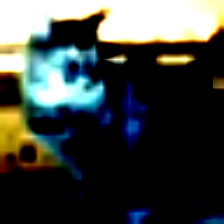

cat


In [13]:
index = 0

image = cv2.resize(data[0][index].permute(1, 2, 0).numpy()*255, (224, 224))
label = encoder.inverse_transform(data[1])[index]

cv2_imshow(image)
print(label)

Resnet 18

In [43]:
class block(nn.Module):
   def __init__(self,in_channels,out_channels,identity_downsample = None,stride = 1):
     super(block, self).__init__()
     self.conv1 = nn. Conv2d(in_channels,out_channels,kernel_size=3,padding = 1,stride = stride)
     self.bn1 = nn.BatchNorm2d(out_channels)
     self.conv2 = nn. Conv2d(out_channels,out_channels,kernel_size=3,padding = 1,stride = 1)
     self.bn2 = nn.BatchNorm2d(out_channels)
     self.relu =nn.ReLU()
     self.downsample = identity_downsample

   def forward(self,x):
     identity = x
     x = self.conv1(x)
     x = self.bn1(x)
     x = self.conv2(x)
     x = self.bn2(x)
     if self.downsample is not None:
       identity = self.downsample(identity)
     x += identity
     x = self.relu(x)
     return x

class Res18(nn.Module):
  def __init__(self,block,img_channels,args):
    super(Res18, self).__init__()
    self.args = args
    self.conv1 = nn.Conv2d(img_channels,64,kernel_size=7,stride=1,padding=3)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size= 3,stride=1,padding =1)
    self.in_channels = 64
    self.layer1 = self._make_layer(block,64,1)
    self.layer2 = self._make_layer(block,128,2)
    self.layer3 = self._make_layer(block,256,2)
    self.layer4 = self._make_layer(block,512,2)
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512,10)

  def _make_layer(self,block,out_channels,stride=1):
    layers = []
    identity_downsample = None
    if (stride != 1) or (self.in_channels != out_channels):
      identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels,out_channels,kernel_size=1,stride=stride),nn.BatchNorm2d(out_channels))
    layers.append(block(self.in_channels,out_channels,identity_downsample,stride))
    self.in_channels = out_channels
    layers.append(block(self.in_channels,out_channels))
    return nn.Sequential(*layers)
  def forward(self,x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    #print(x.shape)
    x = self.maxpool(x)
    x = self.layer1(x)
    #print(x.shape)
    x = self.layer2(x)
    #print(x.shape)
    x = self.layer3(x)
  
    x = self.layer4(x)
    #print(x.shape)
    x = self.avgpool(x)
    x = torch.flatten(x,1)
    #print(x.shape)
    x = self.fc(x)
    return x

# Trainer

In [20]:
class Trainer():
    def __init__(self, args, architecture):

        self.args = args

        random.seed(self.args.seed)
        np.random.seed(self.args.seed)
        torch.manual_seed(self.args.seed)
        torch.cuda.manual_seed(self.args.seed)
        torch.cuda.manual_seed_all(self.args.seed)

        self.trainloader, self.validloader, self.testloader = self.get_iterator(self.args.data)
        
        self.model = architecture.to(self.args.device) # self.get_model()
        self.criterion = self.get_criterion()
        self.optimizer = self.get_optimizer()
        self.scheduler = self.get_scheduler()

        self.train_loss = []
        self.train_metrics = {'accuracy': []}
        self.valid_loss = []
        self.valid_metrics = {'accuracy': []}

        self.start_epoch = 0

    def get_iterator(self, data):
        train, valid, test = data
        trainloader = DataLoader(train, batch_size=self.args.batch_size, shuffle=True, num_workers=self.args.num_workers, pin_memory=True, drop_last=True)
        validloader = DataLoader(valid, batch_size=self.args.batch_size, shuffle=False, num_workers=self.args.num_workers, pin_memory=True, drop_last=True)
        testloader = DataLoader(test, batch_size=self.args.batch_size, shuffle=False, num_workers=self.args.num_workers, pin_memory=True, drop_last=False)
        return trainloader, validloader, testloader

    def get_criterion(self):
        return nn.CrossEntropyLoss(weight=weights).to(self.args.device)
    
    def get_optimizer(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.args.lr)

    def get_scheduler(self):
        return torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, self.args.max_epochs, eta_min=1e-12, last_epoch=-1, verbose=False)

    def get_model(self, architecture):
        model = Convolutional_Network(args).to(self.args.device)
        return model

    def get_model_params(self):
        return sum(p.numel() for p in self.model.parameters())/1e6

    def get_accuracy(self, output, label):
        return (torch.argmax(output, dim=1)==label).float().sum().item()

    def save(self, epoch):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            }, os.path.join(self.args.checkpoint, "model.pth"))
        torch.save({
            'epoch': epoch,
            'args': args,
            'loss': (self.train_loss, self.valid_loss),
            'metrics': (self.train_metrics, self.valid_metrics)
            }, os.path.join(self.args.checkpoint, "metrics.pth"))
        
    def load(self):
        if os.path.exists(os.path.join(self.args.checkpoint, "model.pth")):
            checkpoints = torch.load(os.path.join(self.args.checkpoint, "model.pth"), map_location=self.args.device)
            self.model.load_state_dict(checkpoints['model_state_dict'])
            self.optimizer.load_state_dict(checkpoints['optimizer_state_dict'])

        if os.path.exists(os.path.join(self.args.checkpoint, "metrics.pth")):
            checkpoints = torch.load(os.path.join(self.args.checkpoint, "metrics.pth"), map_location=self.args.device)
            self.args = checkpoints['args']
            self.train_loss, self.valid_loss = checkpoints['loss']
            self.train_metrics, self.valid_metrics = checkpoints['metrics']
            return checkpoints['epoch']
        return 0

    def train(self):
        epoch_loss = 0
        epoch_metrics = {'accuracy': 0}

        gc.collect()
        torch.cuda.empty_cache()
        self.model.train()

        with torch.autograd.set_detect_anomaly(True):
            bar = pyprind.ProgBar(len(self.trainloader), bar_char='█')
            for index, (data, label) in enumerate(self.trainloader):
                data = data.to(self.args.device).float()
                label = label.long().to(self.args.device)

                self.optimizer.zero_grad()
                
                output = self.model(data)

                loss = self.criterion(output, label)

                loss.backward()

                self.optimizer.step()

                epoch_loss += loss.item()/len(self.trainloader)

                epoch_metrics['accuracy'] += self.get_accuracy(output, label)/len(self.args.data[0])

                bar.update()
                gc.collect()
                torch.cuda.empty_cache()

        return epoch_loss, epoch_metrics

    def evaluate(self):
        epoch_loss = 0
        epoch_metrics = {'accuracy': 0}

        gc.collect()
        torch.cuda.empty_cache()
        self.model.eval()

        with torch.autograd.set_detect_anomaly(True):
            with torch.no_grad():
                bar = pyprind.ProgBar(len(self.validloader), bar_char='█')
                for index, (data, label) in enumerate(self.validloader):
                    data = data.to(self.args.device).float()
                    label = label.long().to(self.args.device)

                    output = self.model(data)

                    loss = self.criterion(output, label)

                    epoch_loss += loss.item()/len(self.validloader)
                    epoch_metrics['accuracy'] += self.get_accuracy(output, label)/len(self.args.data[1])

                    bar.update()
                    gc.collect()
                    torch.cuda.empty_cache()

        return epoch_loss, epoch_metrics

    def test(self):

        gc.collect()
        torch.cuda.empty_cache()
        self.model.eval()

        outputs = torch.empty([0,])

        with torch.autograd.set_detect_anomaly(True):
            with torch.no_grad():
                bar = pyprind.ProgBar(len(self.testloader), bar_char='█')
                for index, (data, label) in enumerate(self.testloader):
                    data = data.to(self.args.device)

                    output = torch.argmax(self.model(data)).detach().cpu()
                    outputs = torch.cat((outputs, output), dim=0)

                    bar.update()
                    gc.collect()
                    torch.cuda.empty_cache()

        return outputs
    
    def fit(self, next=True):
        if next:
            self.start_epoch = self.load()

        for epoch in range(self.start_epoch+1, self.args.max_epochs+1, 1):

            epoch_train_loss, epoch_train_metrics = self.train()
            epoch_train_accuracy = epoch_train_metrics['accuracy']

            self.train_loss.append(epoch_train_loss)
            self.train_metrics['accuracy'].append(epoch_train_metrics['accuracy'])

            epoch_valid_loss, epoch_valid_metrics = self.evaluate()
            epoch_valid_accuracy = epoch_valid_metrics['accuracy']

            
            self.valid_loss.append(epoch_valid_loss)
            self.valid_metrics['accuracy'].append(epoch_valid_metrics['accuracy']) 

            self.scheduler.step()
            for param_group in self.optimizer.param_groups:
                self.args.lr = param_group['lr']
            if epoch_valid_metrics['accuracy'] >= max(self.valid_metrics['accuracy']):
                self.save(epoch)

            time.sleep(1)
            print(f'Epoch {epoch}/{self.args.max_epochs} | Training: Loss = {round(epoch_train_loss, 4)}  Accuracy = {round(epoch_train_accuracy, 4)} | Validation: Loss = {round(epoch_valid_loss, 4)}  Accuracy = {round(epoch_valid_accuracy, 4)}')

# Training

In [44]:
models = {
    'Res18': Res18(block,3,args),
}

In [45]:
trainer = Trainer(args, architecture=models['Res18'])

In [46]:
trainer.fit()

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:02:15
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


Epoch 1/10 | Training: Loss = 1.2649  Accuracy = 0.5425 | Validation: Loss = 1.0881  Accuracy = 0.6216


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:02:13
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


Epoch 2/10 | Training: Loss = 0.8874  Accuracy = 0.688 | Validation: Loss = 0.9412  Accuracy = 0.6788


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:02:13
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


Epoch 3/10 | Training: Loss = 0.7119  Accuracy = 0.7507 | Validation: Loss = 0.7386  Accuracy = 0.7424


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:02:13
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


Epoch 4/10 | Training: Loss = 0.5802  Accuracy = 0.7994 | Validation: Loss = 0.6894  Accuracy = 0.7532


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:02:13
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


Epoch 5/10 | Training: Loss = 0.4719  Accuracy = 0.8358 | Validation: Loss = 0.6563  Accuracy = 0.7788


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:02:13
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


Epoch 6/10 | Training: Loss = 0.3484  Accuracy = 0.8783 | Validation: Loss = 0.6789  Accuracy = 0.7792


KeyboardInterrupt: ignored